<a href="https://colab.research.google.com/github/Deeksha-Pandit/EVA4-S6/blob/master/L1_L2_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        dropout_value=0.05
        
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
        ) # RF=3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
        ) # RF=5

      # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # RF=6
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
        ) # RF=10


        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value),
        ) # RF=14

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
        ) # RF=18

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
        ) # RF=22

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
        ) # RF=26

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 20, 10, 10]           1,800
             ReLU-11           [-1, 20, 10, 10]               0
      BatchNorm2d-12           [-1, 20, 10, 10]              40
          Dropout-13           [-1, 20, 10, 10]               0
           Conv2d-14             [

In [0]:
#L1 regularisation model
def L1_Loss(model, data, factor=0.0005):
  l1_crit = nn.L1Loss().to(device)
  reg_loss = 0
  
  for param in model.parameters():
    zero_vector = torch.rand_like(param) * 0
    reg_loss += l1_crit(param, zero_vector)

  return factor * reg_loss

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, is_L1=False):
  is_L1=True
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if(is_L1==True):
      loss += L1_Loss(model,data,factor=0.0005)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_losses, test_acc, misclassified):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            for i in range(len(pred)):
              if pred[i]!= target[i]:
                misclassified.append([data[i], pred[i], target[i]])
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
"""from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch, "lr:",optimizer.param_groups[0]["lr"])
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)"""

In [0]:
#Plotting graphs
%matplotlib inline
import matplotlib.pyplot as plt
def plot_test_loss_acc(test_losses,test_acc):
  fig, axs = plt.subplots(1,2,figsize=(15,10))
  axs[0].plot(test_losses)
  axs[0].set_title("Test Loss")
  axs[1].plot(test_acc)
  axs[1].set_title("Test Accuracy")

In [0]:

def plot_misclassified(misclassified):
  fig = plt.figure(figsize = (10,10))
  for i in range(25):
        sub = fig.add_subplot(5, 5, i+1)
        plt.imshow(misclassified[i][0].cpu().numpy().squeeze(),cmap='gray',interpolation='none')
        
        sub.set_title("Pred={}, Act={}".format(str(misclassified[i][1].data.cpu().numpy()),str(misclassified[i][2].data.cpu().numpy())))
        
  plt.tight_layout()

  plt.show()

In [0]:
test_without_L1L2_Loss = []
test_without_L1L2_acc = []
misclassified_withoutL1L2= []

def without_L1L2():
  
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, False)
      test(model, device, test_loader, test_without_L1L2_Loss, test_without_L1L2_acc, misclassified_withoutL1L2)

  plot_test_loss_acc(test_without_L1L2_Loss,test_without_L1L2_acc)
  plot_misclassified(misclassified_withoutL1L2)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.07366598397493362 Batch_id=468 Accuracy=90.03: 100%|██████████| 469/469 [00:13<00:00, 34.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9842/10000 (98.42%)

EPOCH: 1


Loss=0.06894513964653015 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:13<00:00, 35.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9879/10000 (98.79%)

EPOCH: 2


Loss=0.01581062562763691 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 34.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9914/10000 (99.14%)

EPOCH: 3


Loss=0.01964578777551651 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:16<00:00, 27.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9903/10000 (99.03%)

EPOCH: 4


Loss=0.0670526847243309 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:14<00:00, 32.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


Loss=0.10596517473459244 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:15<00:00, 31.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9931/10000 (99.31%)

EPOCH: 6


Loss=0.07147551327943802 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 32.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9932/10000 (99.32%)

EPOCH: 7


Loss=0.05177242308855057 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 32.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.09370681643486023 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 32.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Loss=0.014573002234101295 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.014733398333191872 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 43.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.05749392881989479 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 31.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.03984853997826576 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 32.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Loss=0.020284777507185936 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 32.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.026534900069236755 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9941/10000 (99.41%)

EPOCH: 15


Loss=0.013986913487315178 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:14<00:00, 31.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.006007037591189146 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:14<00:00, 31.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99.39%)

EPOCH: 17


Loss=0.01849454641342163 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 32.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.024569686502218246 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 31.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9942/10000 (99.42%)

EPOCH: 19


Loss=0.015488708391785622 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:13<00:00, 41.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9946/10000 (99.46%)

EPOCH: 20


Loss=0.013828622177243233 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:14<00:00, 32.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9936/10000 (99.36%)

EPOCH: 21


Loss=0.0069163767620921135 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:14<00:00, 31.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9942/10000 (99.42%)

EPOCH: 22


Loss=0.013692120090126991 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:14<00:00, 32.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9947/10000 (99.47%)

EPOCH: 23


Loss=0.017197642475366592 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:14<00:00, 32.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9944/10000 (99.44%)

EPOCH: 24


Loss=0.02354085072875023 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:14<00:00, 31.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9935/10000 (99.35%)

EPOCH: 25


Loss=0.017062921077013016 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9942/10000 (99.42%)

EPOCH: 26


Loss=0.007725960575044155 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:14<00:00, 42.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9948/10000 (99.48%)

EPOCH: 27


Loss=0.011004878208041191 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:14<00:00, 31.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9935/10000 (99.35%)

EPOCH: 28


Loss=0.018291378393769264 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:14<00:00, 32.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9935/10000 (99.35%)

EPOCH: 29


Loss=0.009597938507795334 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:14<00:00, 31.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9941/10000 (99.41%)

EPOCH: 30


Loss=0.007239409256726503 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:14<00:00, 31.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9940/10000 (99.40%)

EPOCH: 31


Loss=0.006983097642660141 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:14<00:00, 31.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9944/10000 (99.44%)

EPOCH: 32


Loss=0.009538674727082253 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:15<00:00, 31.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9943/10000 (99.43%)

EPOCH: 33


Loss=0.03542332351207733 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:14<00:00, 32.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9950/10000 (99.50%)

EPOCH: 34


Loss=0.006702303886413574 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:15<00:00, 30.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9933/10000 (99.33%)

EPOCH: 35


Loss=0.005498858168721199 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:14<00:00, 31.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9948/10000 (99.48%)

EPOCH: 36


Loss=0.010504402220249176 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:14<00:00, 31.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9942/10000 (99.42%)

EPOCH: 37


Loss=0.027568776160478592 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 38


Loss=0.007177802734076977 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:14<00:00, 33.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9942/10000 (99.42%)

EPOCH: 39


Loss=0.00912329088896513 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:14<00:00, 32.21it/s]



Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)



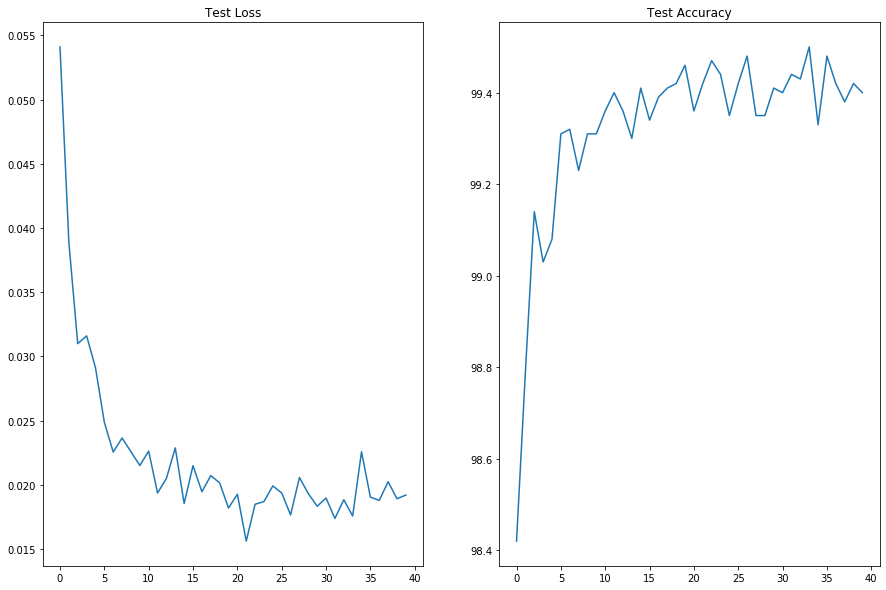

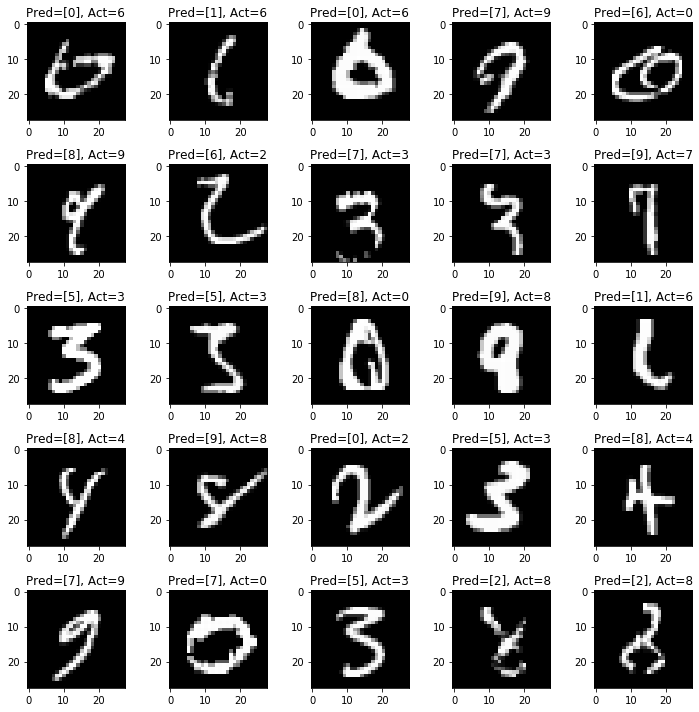

In [34]:
without_L1L2()

In [0]:
test_with_L1_Loss = []
test_with_L1_acc = []
misclassified_L1 = []

def with_L1():
    
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, True)
      test(model, device, test_loader, test_with_L1_Loss, test_with_L1_acc, misclassified_L1)

  plot_test_loss_acc(test_with_L1_Loss, test_with_L1_acc)
  plot_misclassified(misclassified_L1)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.08880968391895294 Batch_id=468 Accuracy=90.86: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Accuracy: 9846/10000 (98.46%)

EPOCH: 1


Loss=0.07714783400297165 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:13<00:00, 34.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9889/10000 (98.89%)

EPOCH: 2


Loss=0.07880085706710815 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:13<00:00, 34.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9901/10000 (99.01%)

EPOCH: 3


Loss=0.03999490290880203 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Loss=0.03433680534362793 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 34.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9926/10000 (99.26%)

EPOCH: 5


Loss=0.029227441176772118 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:13<00:00, 34.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)

EPOCH: 6


Loss=0.008755482733249664 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 33.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9921/10000 (99.21%)

EPOCH: 7


Loss=0.02751125767827034 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 35.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9932/10000 (99.32%)

EPOCH: 8


Loss=0.046327147632837296 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 34.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


Loss=0.04568811506032944 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 41.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.05091563239693642 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 34.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.023648064583539963 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 34.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


Loss=0.03760112076997757 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 34.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9945/10000 (99.45%)

EPOCH: 13


Loss=0.03560303524136543 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 34.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


Loss=0.017680224031209946 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 36.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Loss=0.02300027385354042 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:13<00:00, 34.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

EPOCH: 16


Loss=0.02740618586540222 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Loss=0.024955008178949356 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:13<00:00, 35.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.009421016089618206 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:12<00:00, 36.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Loss=0.015073543414473534 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9927/10000 (99.27%)

EPOCH: 20


Loss=0.022061888128519058 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:13<00:00, 34.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9920/10000 (99.20%)

EPOCH: 21


Loss=0.01831701397895813 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:13<00:00, 35.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9945/10000 (99.45%)

EPOCH: 22


Loss=0.01580057106912136 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:13<00:00, 34.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9943/10000 (99.43%)

EPOCH: 23


Loss=0.006779695861041546 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9933/10000 (99.33%)

EPOCH: 24


Loss=0.0076461490243673325 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:13<00:00, 42.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9942/10000 (99.42%)

EPOCH: 25


Loss=0.006248991470783949 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:13<00:00, 34.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9947/10000 (99.47%)

EPOCH: 26


Loss=0.009683423675596714 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:13<00:00, 33.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9941/10000 (99.41%)

EPOCH: 27


Loss=0.03125232085585594 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:13<00:00, 33.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9940/10000 (99.40%)

EPOCH: 28


Loss=0.0402793325483799 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:14<00:00, 33.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9944/10000 (99.44%)

EPOCH: 29


Loss=0.00812729075551033 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:13<00:00, 34.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9944/10000 (99.44%)

EPOCH: 30


Loss=0.02434980496764183 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:13<00:00, 34.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9948/10000 (99.48%)

EPOCH: 31


Loss=0.051644664257764816 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:13<00:00, 34.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9945/10000 (99.45%)

EPOCH: 32


Loss=0.13010533154010773 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:13<00:00, 34.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9948/10000 (99.48%)

EPOCH: 33


Loss=0.006597715895622969 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9946/10000 (99.46%)

EPOCH: 34


Loss=0.010371716693043709 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:13<00:00, 35.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9937/10000 (99.37%)

EPOCH: 35


Loss=0.009400840848684311 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:13<00:00, 33.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)

EPOCH: 36


Loss=0.014163014478981495 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:13<00:00, 39.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

EPOCH: 37


Loss=0.03882715106010437 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:13<00:00, 34.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9941/10000 (99.41%)

EPOCH: 38


Loss=0.029355797916650772 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:13<00:00, 34.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9940/10000 (99.40%)

EPOCH: 39


Loss=0.01565714366734028 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:13<00:00, 34.15it/s]



Test set: Average loss: 0.0176, Accuracy: 9941/10000 (99.41%)



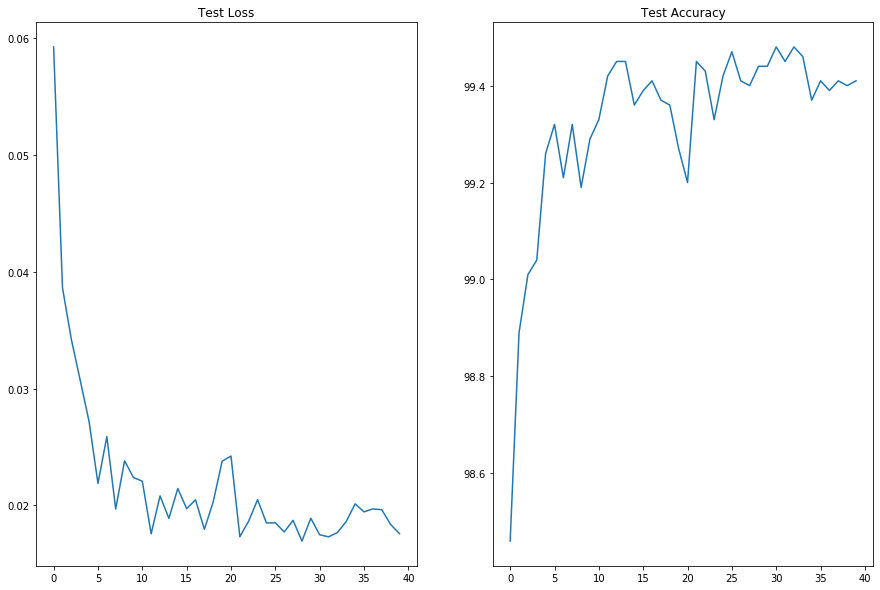

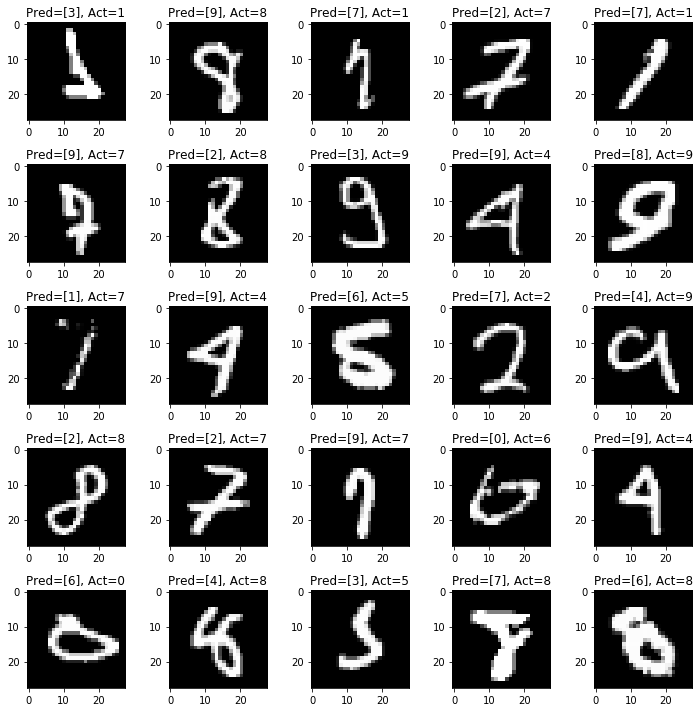

In [30]:
with_L1()

In [0]:
test_with_L2_Loss = []
test_with_L2_acc = []
misclassified_L2 = []

def with_L2():
    
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, False)
      test(model, device, test_loader, test_with_L2_Loss, test_with_L2_acc, misclassified_L2)

  plot_test_loss_acc(test_with_L2_Loss,test_with_L2_acc)
  plot_misclassified(misclassified_L2)



  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.07622643560171127 Batch_id=468 Accuracy=91.11: 100%|██████████| 469/469 [00:13<00:00, 34.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0725, Accuracy: 9836/10000 (98.36%)

EPOCH: 1


Loss=0.06498342007398605 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:13<00:00, 35.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0545, Accuracy: 9866/10000 (98.66%)

EPOCH: 2


Loss=0.10811790823936462 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:12<00:00, 40.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9893/10000 (98.93%)

EPOCH: 3


Loss=0.06721287965774536 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:13<00:00, 35.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 9875/10000 (98.75%)

EPOCH: 4


Loss=0.07142815738916397 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:13<00:00, 35.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 9896/10000 (98.96%)

EPOCH: 5


Loss=0.09010641276836395 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 35.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 9883/10000 (98.83%)

EPOCH: 6


Loss=0.05288463830947876 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 40.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0515, Accuracy: 9893/10000 (98.93%)

EPOCH: 7


Loss=0.06938480585813522 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:13<00:00, 35.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9910/10000 (99.10%)

EPOCH: 8


Loss=0.031201990321278572 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 34.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9911/10000 (99.11%)

EPOCH: 9


Loss=0.048445723950862885 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 34.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9894/10000 (98.94%)

EPOCH: 10


Loss=0.08648163825273514 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 35.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0590, Accuracy: 9871/10000 (98.71%)

EPOCH: 11


Loss=0.07941235601902008 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:12<00:00, 42.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9907/10000 (99.07%)

EPOCH: 12


Loss=0.0668596550822258 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 33.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0580, Accuracy: 9869/10000 (98.69%)

EPOCH: 13


Loss=0.028201736509799957 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 41.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0560, Accuracy: 9869/10000 (98.69%)

EPOCH: 14


Loss=0.03378387540578842 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 41.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0571, Accuracy: 9871/10000 (98.71%)

EPOCH: 15


Loss=0.05872809886932373 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:13<00:00, 42.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9885/10000 (98.85%)

EPOCH: 16


Loss=0.0745287537574768 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:14<00:00, 33.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9882/10000 (98.82%)

EPOCH: 17


Loss=0.04758512228727341 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0528, Accuracy: 9880/10000 (98.80%)

EPOCH: 18


Loss=0.033710088580846786 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:13<00:00, 33.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0623, Accuracy: 9857/10000 (98.57%)

EPOCH: 19


Loss=0.09184480458498001 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:13<00:00, 43.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Accuracy: 9871/10000 (98.71%)

EPOCH: 20


Loss=0.04210812225937843 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9904/10000 (99.04%)

EPOCH: 21


Loss=0.057691287249326706 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:13<00:00, 35.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9906/10000 (99.06%)

EPOCH: 22


Loss=0.1062287911772728 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 34.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0530, Accuracy: 9884/10000 (98.84%)

EPOCH: 23


Loss=0.07737400382757187 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9894/10000 (98.94%)

EPOCH: 24


Loss=0.08145029097795486 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 33.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9914/10000 (99.14%)

EPOCH: 25


Loss=0.031937602907419205 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 34.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0498, Accuracy: 9890/10000 (98.90%)

EPOCH: 26


Loss=0.08256237953901291 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:13<00:00, 34.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0613, Accuracy: 9881/10000 (98.81%)

EPOCH: 27


Loss=0.09585434198379517 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:13<00:00, 34.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0511, Accuracy: 9889/10000 (98.89%)

EPOCH: 28


Loss=0.05184958502650261 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:13<00:00, 34.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 9870/10000 (98.70%)

EPOCH: 29


Loss=0.02519962750375271 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:13<00:00, 35.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0825, Accuracy: 9815/10000 (98.15%)

EPOCH: 30


Loss=0.07670162618160248 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:13<00:00, 35.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0513, Accuracy: 9880/10000 (98.80%)

EPOCH: 31


Loss=0.07329846173524857 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 34.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Accuracy: 9897/10000 (98.97%)

EPOCH: 32


Loss=0.10397681593894958 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:13<00:00, 34.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9921/10000 (99.21%)

EPOCH: 33


Loss=0.05678163096308708 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:13<00:00, 35.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0589, Accuracy: 9875/10000 (98.75%)

EPOCH: 34


Loss=0.08903197199106216 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:13<00:00, 34.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9900/10000 (99.00%)

EPOCH: 35


Loss=0.07069086283445358 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:13<00:00, 40.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0803, Accuracy: 9805/10000 (98.05%)

EPOCH: 36


Loss=0.09440454095602036 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:13<00:00, 35.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0666, Accuracy: 9831/10000 (98.31%)

EPOCH: 37


Loss=0.024127231910824776 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 35.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0540, Accuracy: 9864/10000 (98.64%)

EPOCH: 38


Loss=0.04957910627126694 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:13<00:00, 35.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0632, Accuracy: 9849/10000 (98.49%)

EPOCH: 39


Loss=0.05358254164457321 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:13<00:00, 33.59it/s]



Test set: Average loss: 0.0424, Accuracy: 9919/10000 (99.19%)



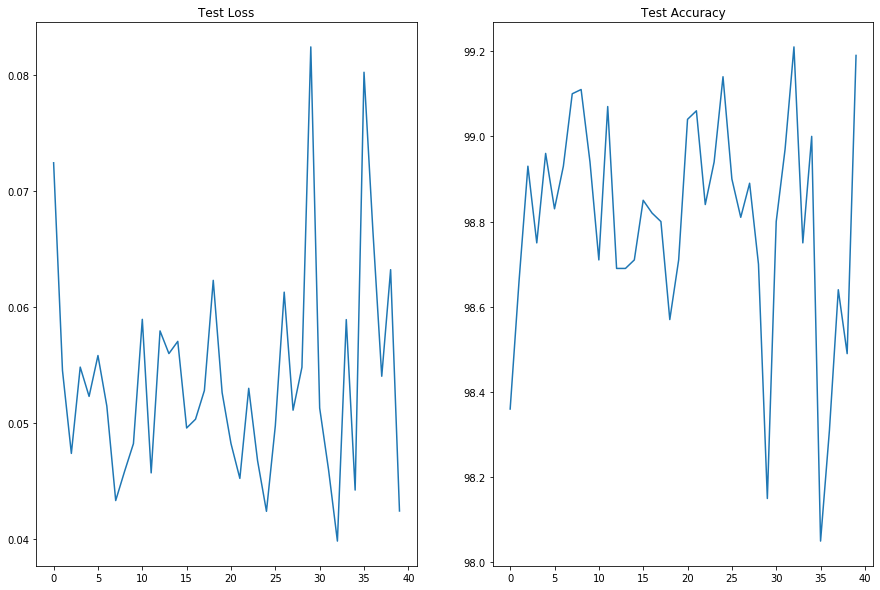

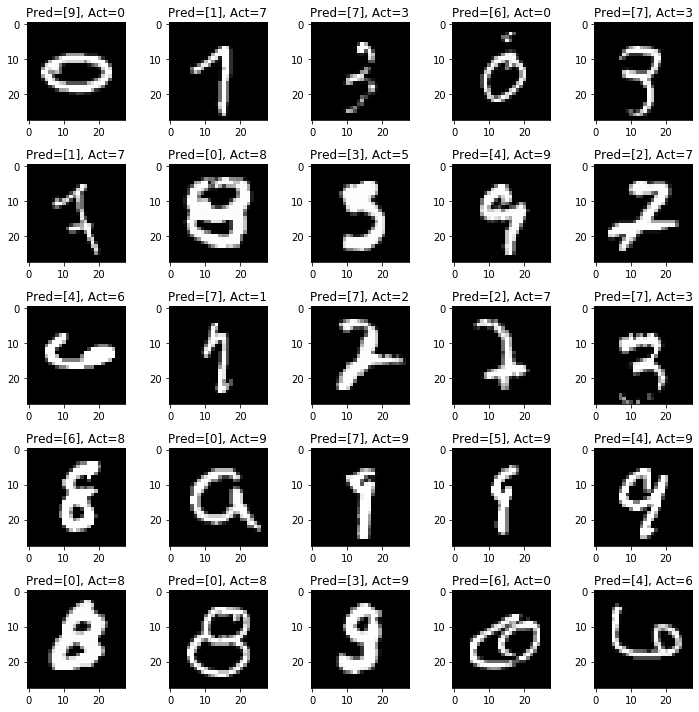

In [26]:
with_L2()

In [0]:
test_with_L1L2_Loss = []
test_with_L1L2_acc = []
misclassified_withL1L2 = []

def with_L1L2():
    
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, True)
      test(model, device, test_loader, test_with_L1L2_Loss, test_with_L1L2_acc, misclassified_withL1L2)

  plot_test_loss_acc(test_with_L1L2_Loss,test_with_L1L2_acc)
  plot_misclassified(misclassified_withL1L2)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.11868855357170105 Batch_id=468 Accuracy=91.81: 100%|██████████| 469/469 [00:13<00:00, 34.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0817, Accuracy: 9809/10000 (98.09%)

EPOCH: 1


Loss=0.08816824853420258 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:13<00:00, 41.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0553, Accuracy: 9872/10000 (98.72%)

EPOCH: 2


Loss=0.05371115356683731 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:13<00:00, 34.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0513, Accuracy: 9886/10000 (98.86%)

EPOCH: 3


Loss=0.11901915073394775 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 32.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0521, Accuracy: 9893/10000 (98.93%)

EPOCH: 4


Loss=0.0798436850309372 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:13<00:00, 33.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9894/10000 (98.94%)

EPOCH: 5


Loss=0.10098837316036224 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 34.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0513, Accuracy: 9891/10000 (98.91%)

EPOCH: 6


Loss=0.028370650485157967 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9911/10000 (99.11%)

EPOCH: 7


Loss=0.07815112173557281 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:13<00:00, 34.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9903/10000 (99.03%)

EPOCH: 8


Loss=0.0591018907725811 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:13<00:00, 35.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9891/10000 (98.91%)

EPOCH: 9


Loss=0.058094821870326996 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:13<00:00, 34.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0652, Accuracy: 9841/10000 (98.41%)

EPOCH: 10


Loss=0.06432690471410751 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 47.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9902/10000 (99.02%)

EPOCH: 11


Loss=0.04954411834478378 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:13<00:00, 34.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9913/10000 (99.13%)

EPOCH: 12


Loss=0.051170408725738525 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 35.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0529, Accuracy: 9881/10000 (98.81%)

EPOCH: 13


Loss=0.039398934692144394 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:13<00:00, 39.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0520, Accuracy: 9886/10000 (98.86%)

EPOCH: 14


Loss=0.03531624749302864 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:13<00:00, 34.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0609, Accuracy: 9857/10000 (98.57%)

EPOCH: 15


Loss=0.04296125844120979 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:13<00:00, 35.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9883/10000 (98.83%)

EPOCH: 16


Loss=0.05264398455619812 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:13<00:00, 41.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0616, Accuracy: 9858/10000 (98.58%)

EPOCH: 17


Loss=0.03685737028717995 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:13<00:00, 41.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0525, Accuracy: 9887/10000 (98.87%)

EPOCH: 18


Loss=0.0459454171359539 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:13<00:00, 35.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9924/10000 (99.24%)

EPOCH: 19


Loss=0.04258774220943451 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:13<00:00, 39.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 9877/10000 (98.77%)

EPOCH: 20


Loss=0.05778662860393524 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 35.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9911/10000 (99.11%)

EPOCH: 21


Loss=0.06976419687271118 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 34.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0557, Accuracy: 9858/10000 (98.58%)

EPOCH: 22


Loss=0.0422600582242012 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 40.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0566, Accuracy: 9868/10000 (98.68%)

EPOCH: 23


Loss=0.10008987039327621 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 34.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0657, Accuracy: 9834/10000 (98.34%)

EPOCH: 24


Loss=0.0555623322725296 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 36.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9904/10000 (99.04%)

EPOCH: 25


Loss=0.032764483243227005 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 34.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9878/10000 (98.78%)

EPOCH: 26


Loss=0.09563042223453522 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 41.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0562, Accuracy: 9881/10000 (98.81%)

EPOCH: 27


Loss=0.16156217455863953 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 35.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9887/10000 (98.87%)

EPOCH: 28


Loss=0.04854581505060196 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:13<00:00, 35.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0530, Accuracy: 9878/10000 (98.78%)

EPOCH: 29


Loss=0.05068051815032959 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:13<00:00, 34.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9894/10000 (98.94%)

EPOCH: 30


Loss=0.05714642256498337 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:13<00:00, 35.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1050, Accuracy: 9726/10000 (97.26%)

EPOCH: 31


Loss=0.0753616988658905 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 35.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0724, Accuracy: 9818/10000 (98.18%)

EPOCH: 32


Loss=0.09046708047389984 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 33.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0538, Accuracy: 9871/10000 (98.71%)

EPOCH: 33


Loss=0.05527814105153084 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 36.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0481, Accuracy: 9894/10000 (98.94%)

EPOCH: 34


Loss=0.05681091919541359 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:15<00:00, 30.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0536, Accuracy: 9879/10000 (98.79%)

EPOCH: 35


Loss=0.0573599599301815 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:13<00:00, 34.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0528, Accuracy: 9881/10000 (98.81%)

EPOCH: 36


Loss=0.05788120999932289 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:13<00:00, 35.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9895/10000 (98.95%)

EPOCH: 37


Loss=0.03380894660949707 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:13<00:00, 33.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9919/10000 (99.19%)

EPOCH: 38


Loss=0.0337265282869339 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 33.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9904/10000 (99.04%)

EPOCH: 39


Loss=0.059373434633016586 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:13<00:00, 35.38it/s]



Test set: Average loss: 0.0603, Accuracy: 9857/10000 (98.57%)



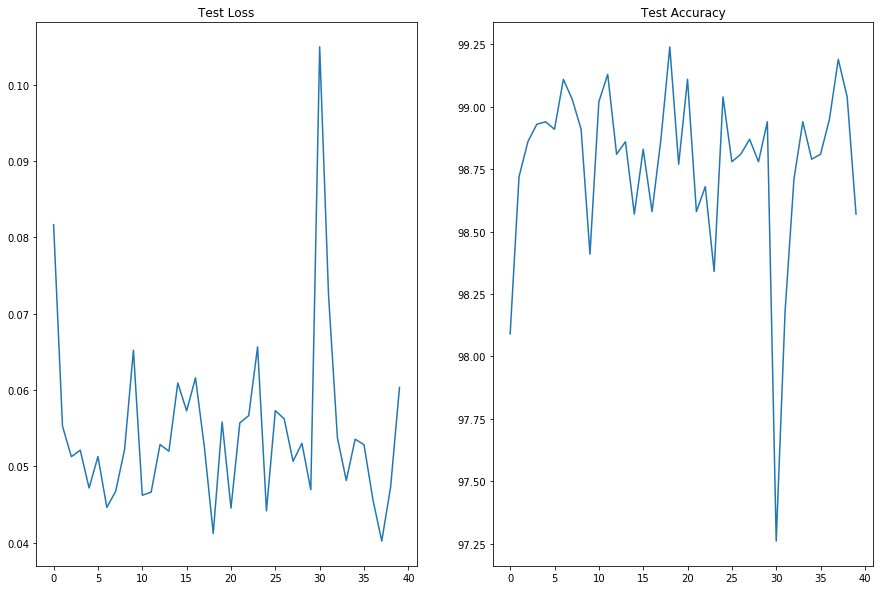

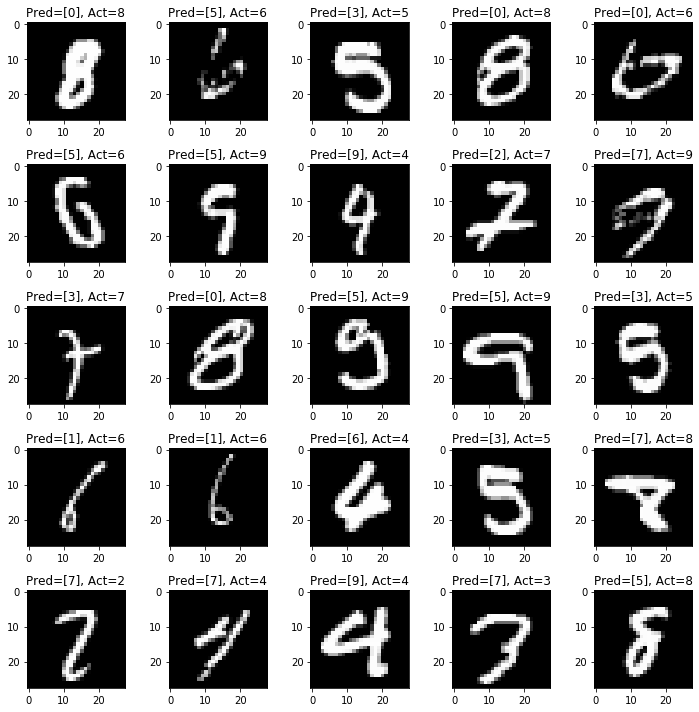

In [32]:
with_L1L2()

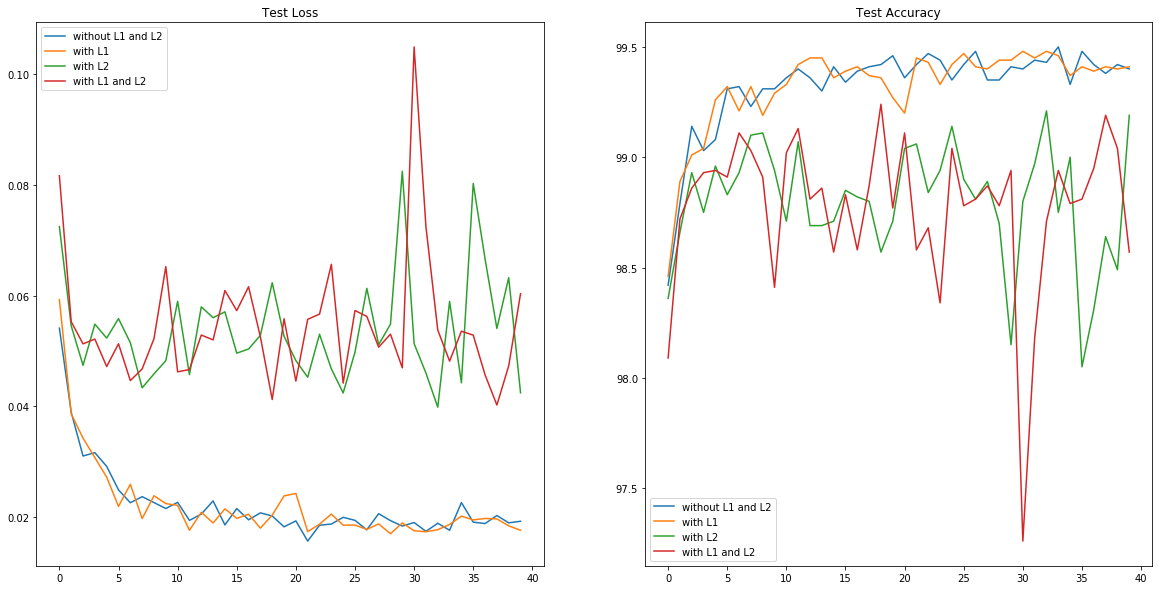

In [36]:
fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].plot(test_without_L1L2_Loss, label='without L1 and L2')
axs[0].plot(test_with_L1_Loss, label='with L1 ')
axs[0].plot(test_with_L2_Loss, label='with L2 ')
axs[0].plot(test_with_L1L2_Loss, label='with L1 and L2 ')
axs[0].set_title("Test Loss")
axs[0].legend()
axs[1].plot(test_without_L1L2_acc, label='without L1 and L2')
axs[1].plot(test_with_L1_acc, label='with L1 ')
axs[1].plot(test_with_L2_acc, label='with L2')
axs[1].plot(test_with_L1L2_acc, label='with L1 and L2 ')
axs[1].set_title("Test Accuracy")
axs[1].legend()